In [3]:
# ! pip install condacolab
# import condacolab
# condacolab.install()

In [6]:
# ! rm -rf /usr/local/conda-meta/pinned
# ! mamba install pygmt numba
# ! pip install --upgrade ppigrf verde ensaio boule harmonica ipywidgets

In [7]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import ppigrf
import verde as vd
import harmonica as hm
import boule as bl
import ensaio
import pygmt

## O campo geomagnéico

In [8]:
date = datetime.datetime(1974, 1, 29)
longitude, latitude = vd.grid_coordinates((-180, 180, -90, 90), spacing=1)
longitude

array([[-180., -179., -178., ...,  178.,  179.,  180.],
       [-180., -179., -178., ...,  178.,  179.,  180.],
       [-180., -179., -178., ...,  178.,  179.,  180.],
       ...,
       [-180., -179., -178., ...,  178.,  179.,  180.],
       [-180., -179., -178., ...,  178.,  179.,  180.],
       [-180., -179., -178., ...,  178.,  179.,  180.]])

In [9]:
bx, by, bz = ppigrf.igrf(longitude, latitude, h=0, date=date)
amplitude = np.sqrt(bx**2 + by**2 + bz**2)

/usr/local/lib/python3.10/site-packages/ppigrf/ppigrf.py:139: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  delta_year = pd.TimedeltaIndex((fracyear - year)*(365 + is_leapyear(year)), unit = 'D')
/usr/local/lib/python3.10/site-packages/ppigrf/ppigrf.py:530: RuntimeWarning: invalid value encountered in divide
  G  = -(RE / r) ** (nn + 1) * mm * np.hstack((-P * sinmphi, P * cosmphi)) \


In [10]:
grid = vd.make_xarray_grid((longitude, latitude), amplitude[0], data_names="amplitude")
grid

<xarray.Dataset>
Dimensions:    (northing: 181, easting: 361)
Coordinates:
  * easting    (easting) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
  * northing   (northing) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
Data variables:
    amplitude  (northing, easting) float64 5.796e+04 5.796e+04 ... nan nan

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.
grdcontour [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


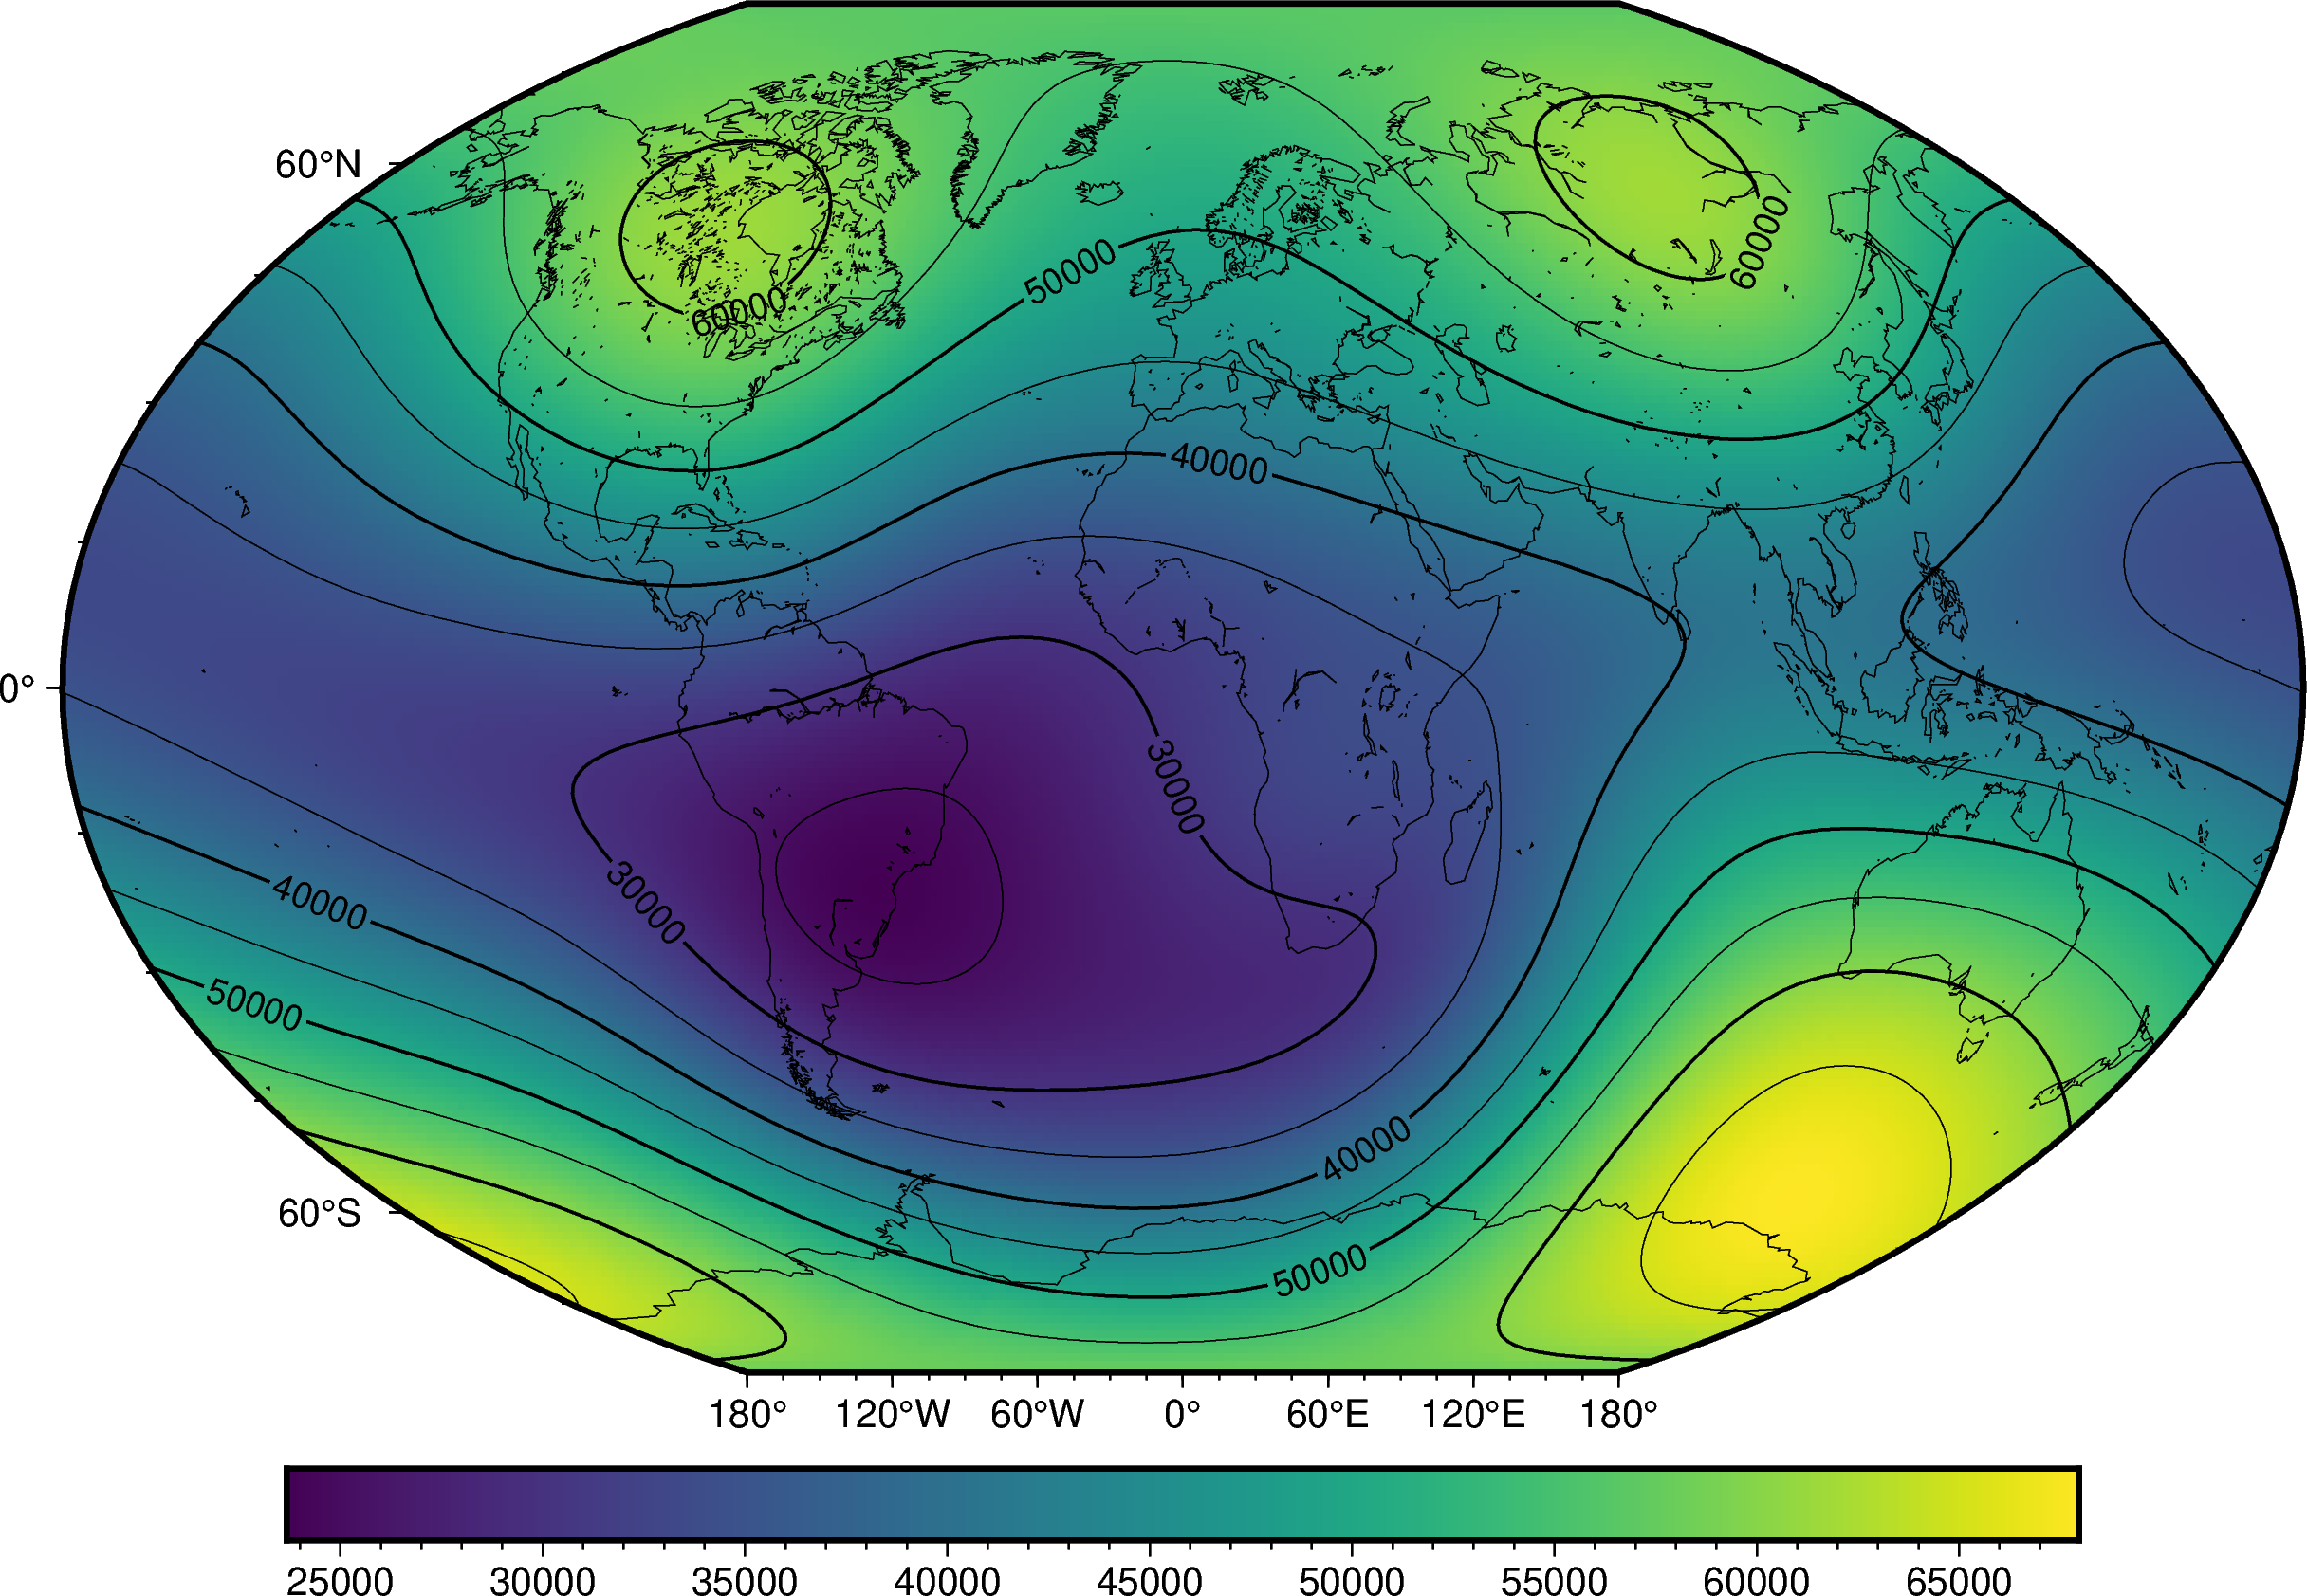

In [11]:
fig = pygmt.Figure()
fig.grdimage(grid.amplitude, projection="R20c", cmap="viridis")
fig.coast(shorelines=True, frame=True)
fig.grdcontour(grid.amplitude)
fig.colorbar()
fig.show(width=800)

## Magnetização

## Anomalias magnéticas

In [ ]:
def angulos_para_xyz(inclinacao, declinacao, amplitude):
    """
    Converte angulos e amplitude para as componentes do vetor.
    Angulos devem ser em graus.
    """
    north = amplitude * np.cos(np.radians(inclinacao)) * np.cos(np.radians(declinacao))
    east = amplitude * np.cos(np.radians(inclinacao)) * np.sin(np.radians(declinacao))
    up = -amplitude * np.sin(np.radians(inclinacao))
    return east, north, up

def anomalia_mag_dipolo(coordinates, inclinacao, declinacao, amplitude, inclinacao_igrf, declinacao_igrf):
    y, x, z = coordinates
    my, mx, mz = angulos_para_xyz(inclinacao, declinacao, amplitude)
    mu0 = 1.25663706212e-6  # N.A^-2
    r = np.sqrt(x**2 + y**2 + z**2)
    mr = x * mx + y * my + z * mz
    bx = mu0 / (4 * np.pi) * (3 * mr * x / r**5 - mx / r**3) * 1e9
    by = mu0 / (4 * np.pi) * (3 * mr * y / r**5 - my / r**3) * 1e9
    bz = mu0 / (4 * np.pi) * (3 * mr * z / r**5 - mz / r**3) * 1e9  # nT
    fy, fx, fz = angulos_para_xyz(inclinacao_igrf, declinacao_igrf, 1)
    return bx * fx + by * fy + bz * fz

In [ ]:
coordinates = vd.grid_coordinates((-50e3, 50e3, -50e3, 50e3), spacing=1000, extra_coords=6000)
anomaly = anomalia_mag_dipolo(coordinates, 30, 0, 1e13, -30, 0)
anomaly

array([[1.71134044, 1.82733065, 1.95002639, ..., 1.95002639, 1.82733065,
        1.71134044],
       [1.69726581, 1.81583548, 1.94148239, ..., 1.94148239, 1.81583548,
        1.69726581],
       [1.67942802, 1.80046283, 1.92895695, ..., 1.92895695, 1.80046283,
        1.67942802],
       ...,
       [1.67942802, 1.80046283, 1.92895695, ..., 1.92895695, 1.80046283,
        1.67942802],
       [1.69726581, 1.81583548, 1.94148239, ..., 1.94148239, 1.81583548,
        1.69726581],
       [1.71134044, 1.82733065, 1.95002639, ..., 1.95002639, 1.82733065,
        1.71134044]])

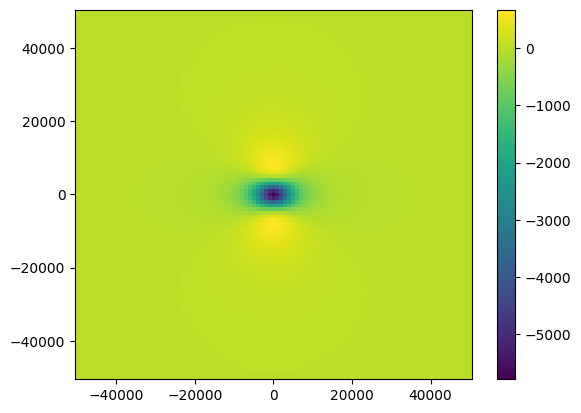

In [ ]:
plt.pcolormesh(*coordinates[:2], anomaly)
plt.colorbar()

## O campo de gravidade

In [ ]:
path = ensaio.fetch_earth_gravity(version=1)
gravity = xr.load_dataarray(path)
gravity

<xarray.DataArray 'gravity' (latitude: 1081, longitude: 2161)>
array([[980106.5 , 980106.5 , 980106.5 , ..., 980106.5 , 980106.5 ,
        980106.5 ],
       [980108.25, 980108.25, 980108.25, ..., 980108.25, 980108.25,
        980108.25],
       [980108.8 , 980108.8 , 980108.8 , ..., 980108.75, 980108.75,
        980108.8 ],
       ...,
       [980153.8 , 980153.75, 980153.6 , ..., 980153.94, 980153.8 ,
        980153.8 ],
       [980160.44, 980160.44, 980160.44, ..., 980160.44, 980160.44,
        980160.44],
       [980157.5 , 980157.5 , 980157.5 , ..., 980157.5 , 980157.5 ,
        980157.5 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04
Attributes:
    Conventions:     CF-1.8
    title:           Gravity acceleration (EIGEN-6C4) at a constant geometric...
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       gravity acceleration
    description:     magnitude of the gravity acceleration vector (gravitatio...
    units:           mGal
    actual_range:    [974748.6 980201.9]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

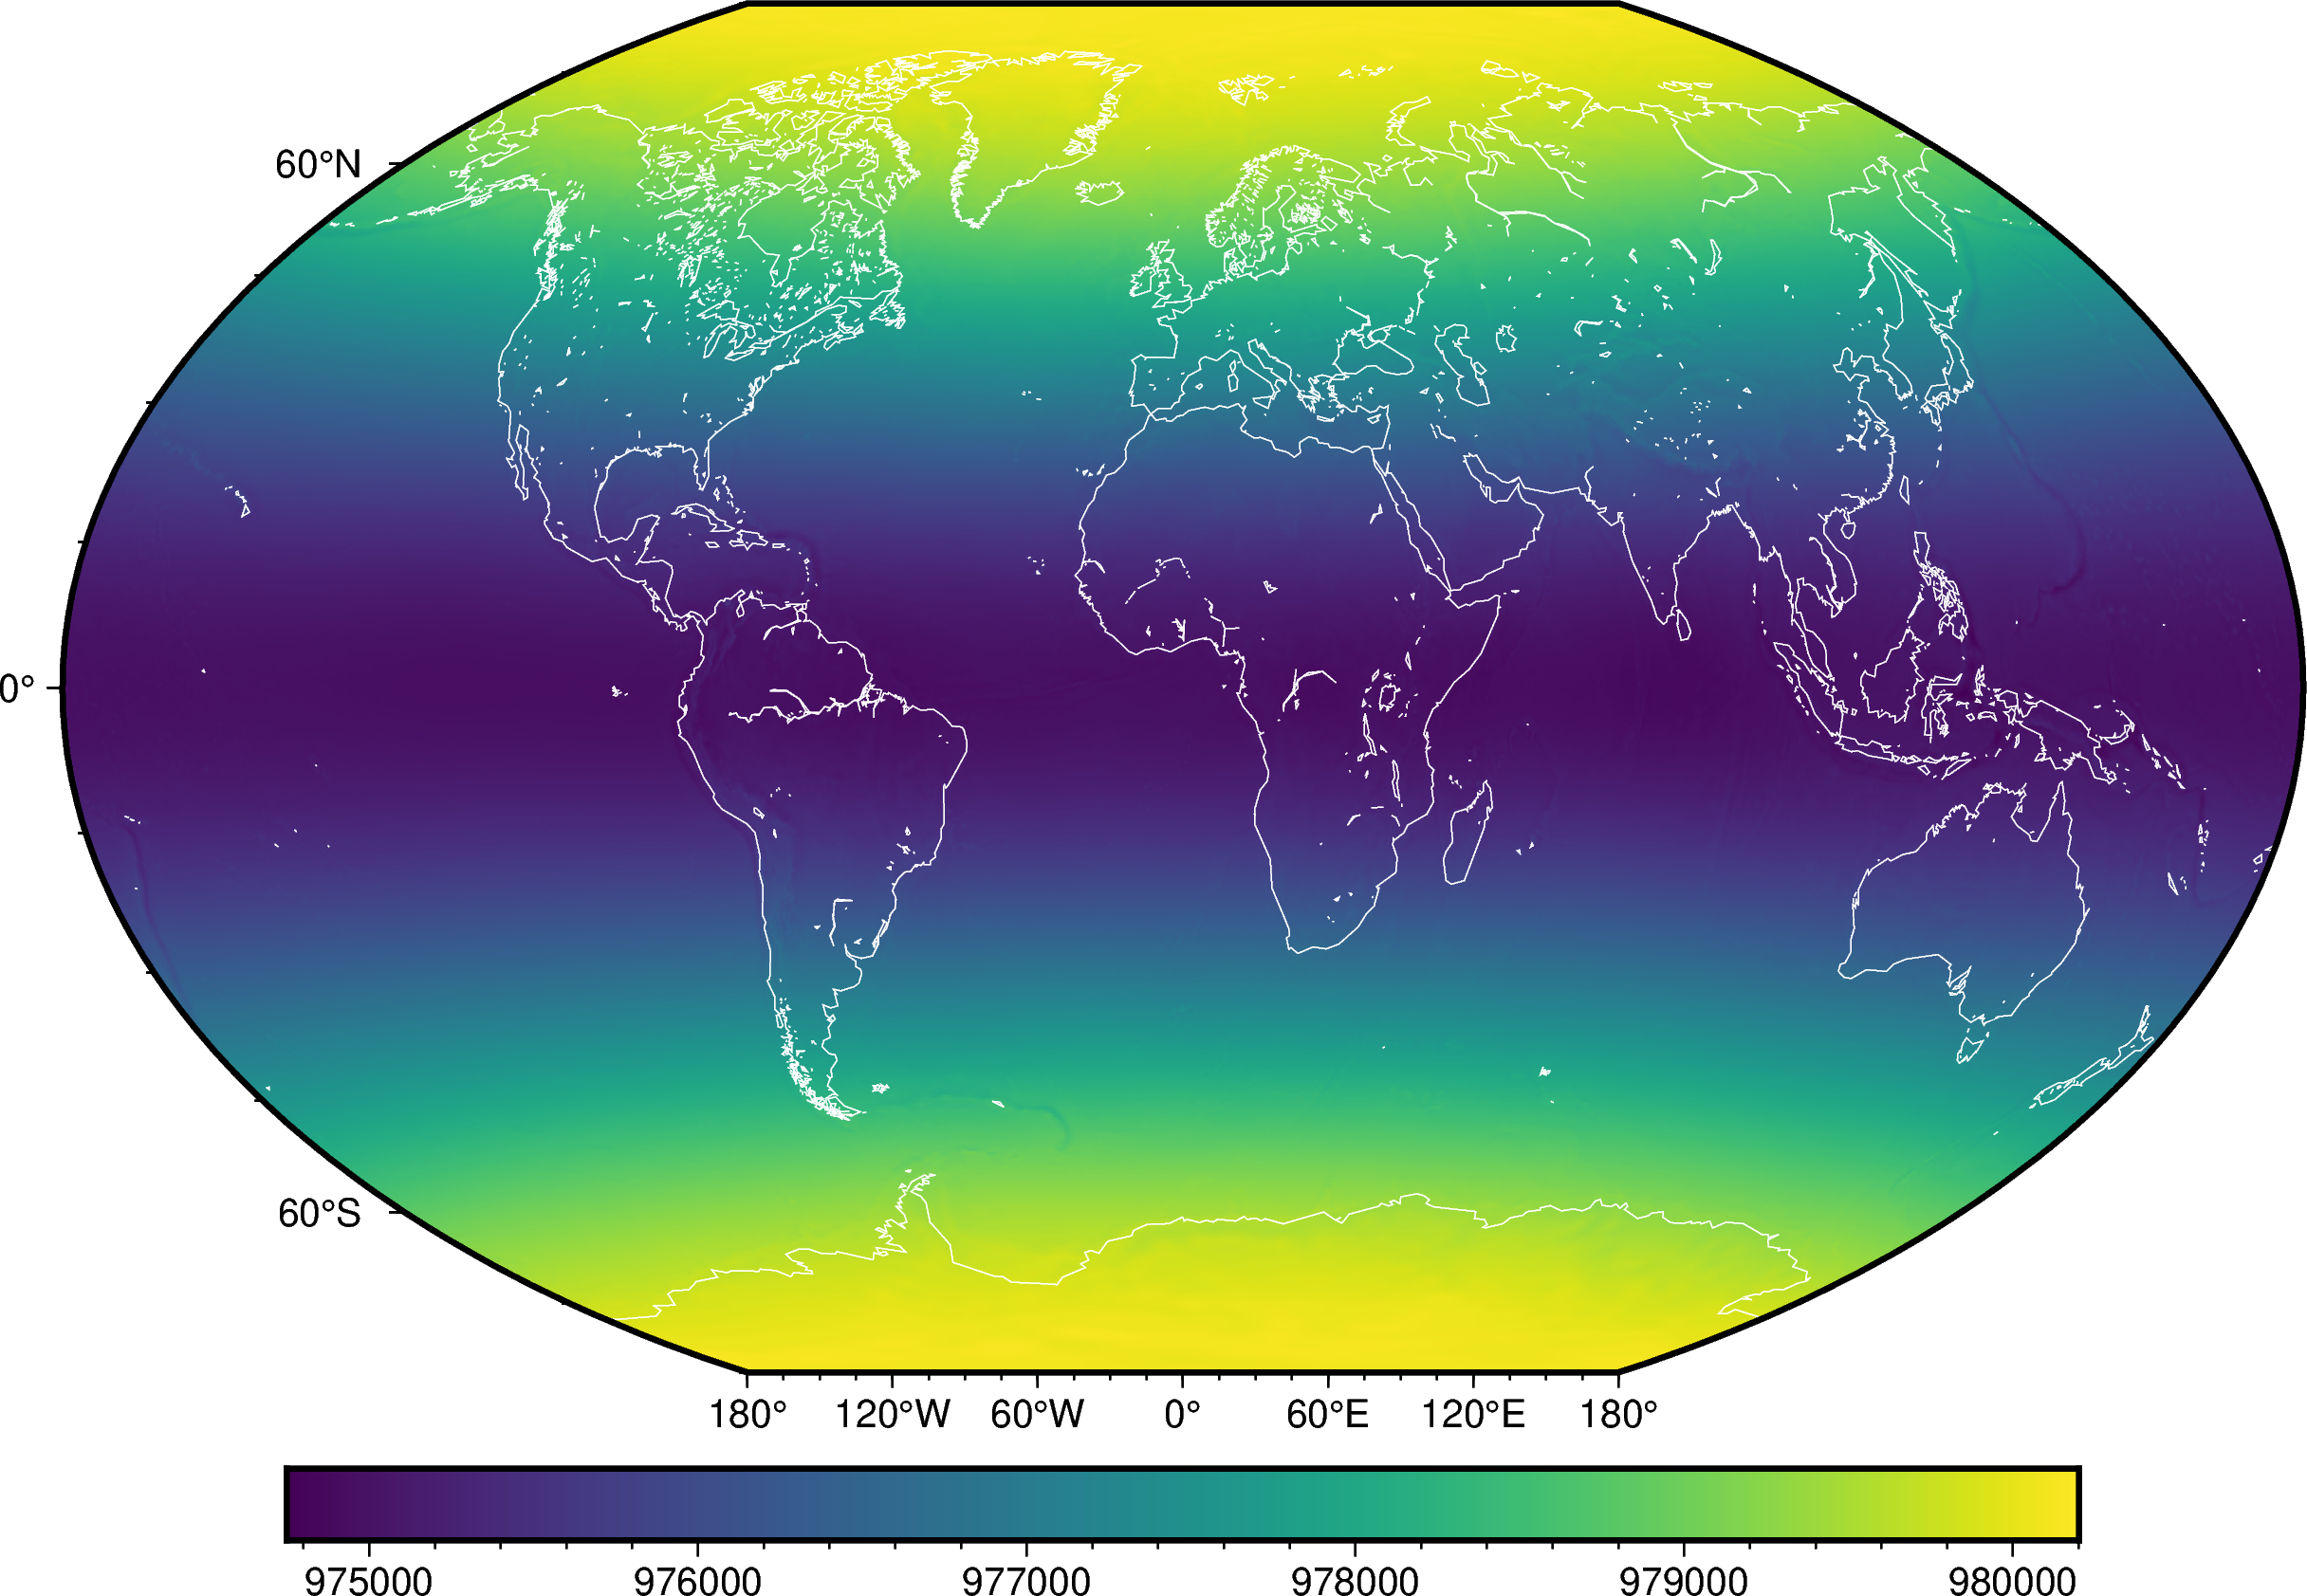

In [ ]:
fig = pygmt.Figure()
fig.grdimage(gravity, projection="R20c", cmap="viridis")
fig.coast(shorelines="white", frame=True)
#fig.grdcontour(gravity)
fig.colorbar()
fig.show(width=800)

## Gravidade Normal

In [ ]:
normal_gravity = bl.WGS84.normal_gravity(gravity.latitude, gravity.height)
normal_gravity

<xarray.DataArray (latitude: 1081, longitude: 2161)>
array([[980142.33509235, 980142.33509235, 980142.33509235, ...,
        980142.33509235, 980142.33509235, 980142.33509235],
       [980142.29097894, 980142.29097894, 980142.29097894, ...,
        980142.29097894, 980142.29097894, 980142.29097894],
       [980142.15864042, 980142.15864042, 980142.15864042, ...,
        980142.15864042, 980142.15864042, 980142.15864042],
       ...,
       [980142.15864042, 980142.15864042, 980142.15864042, ...,
        980142.15864042, 980142.15864042, 980142.15864042],
       [980142.29097894, 980142.29097894, 980142.29097894, ...,
        980142.29097894, 980142.29097894, 980142.29097894],
       [980142.33509235, 980142.33509235, 980142.33509235, ...,
        980142.33509235, 980142.33509235, 980142.33509235]])
Coordinates:
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
    height     (latitude, longitude) float32 1e+04 1e+04 1e+04 ... 1e+04 1e+04

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


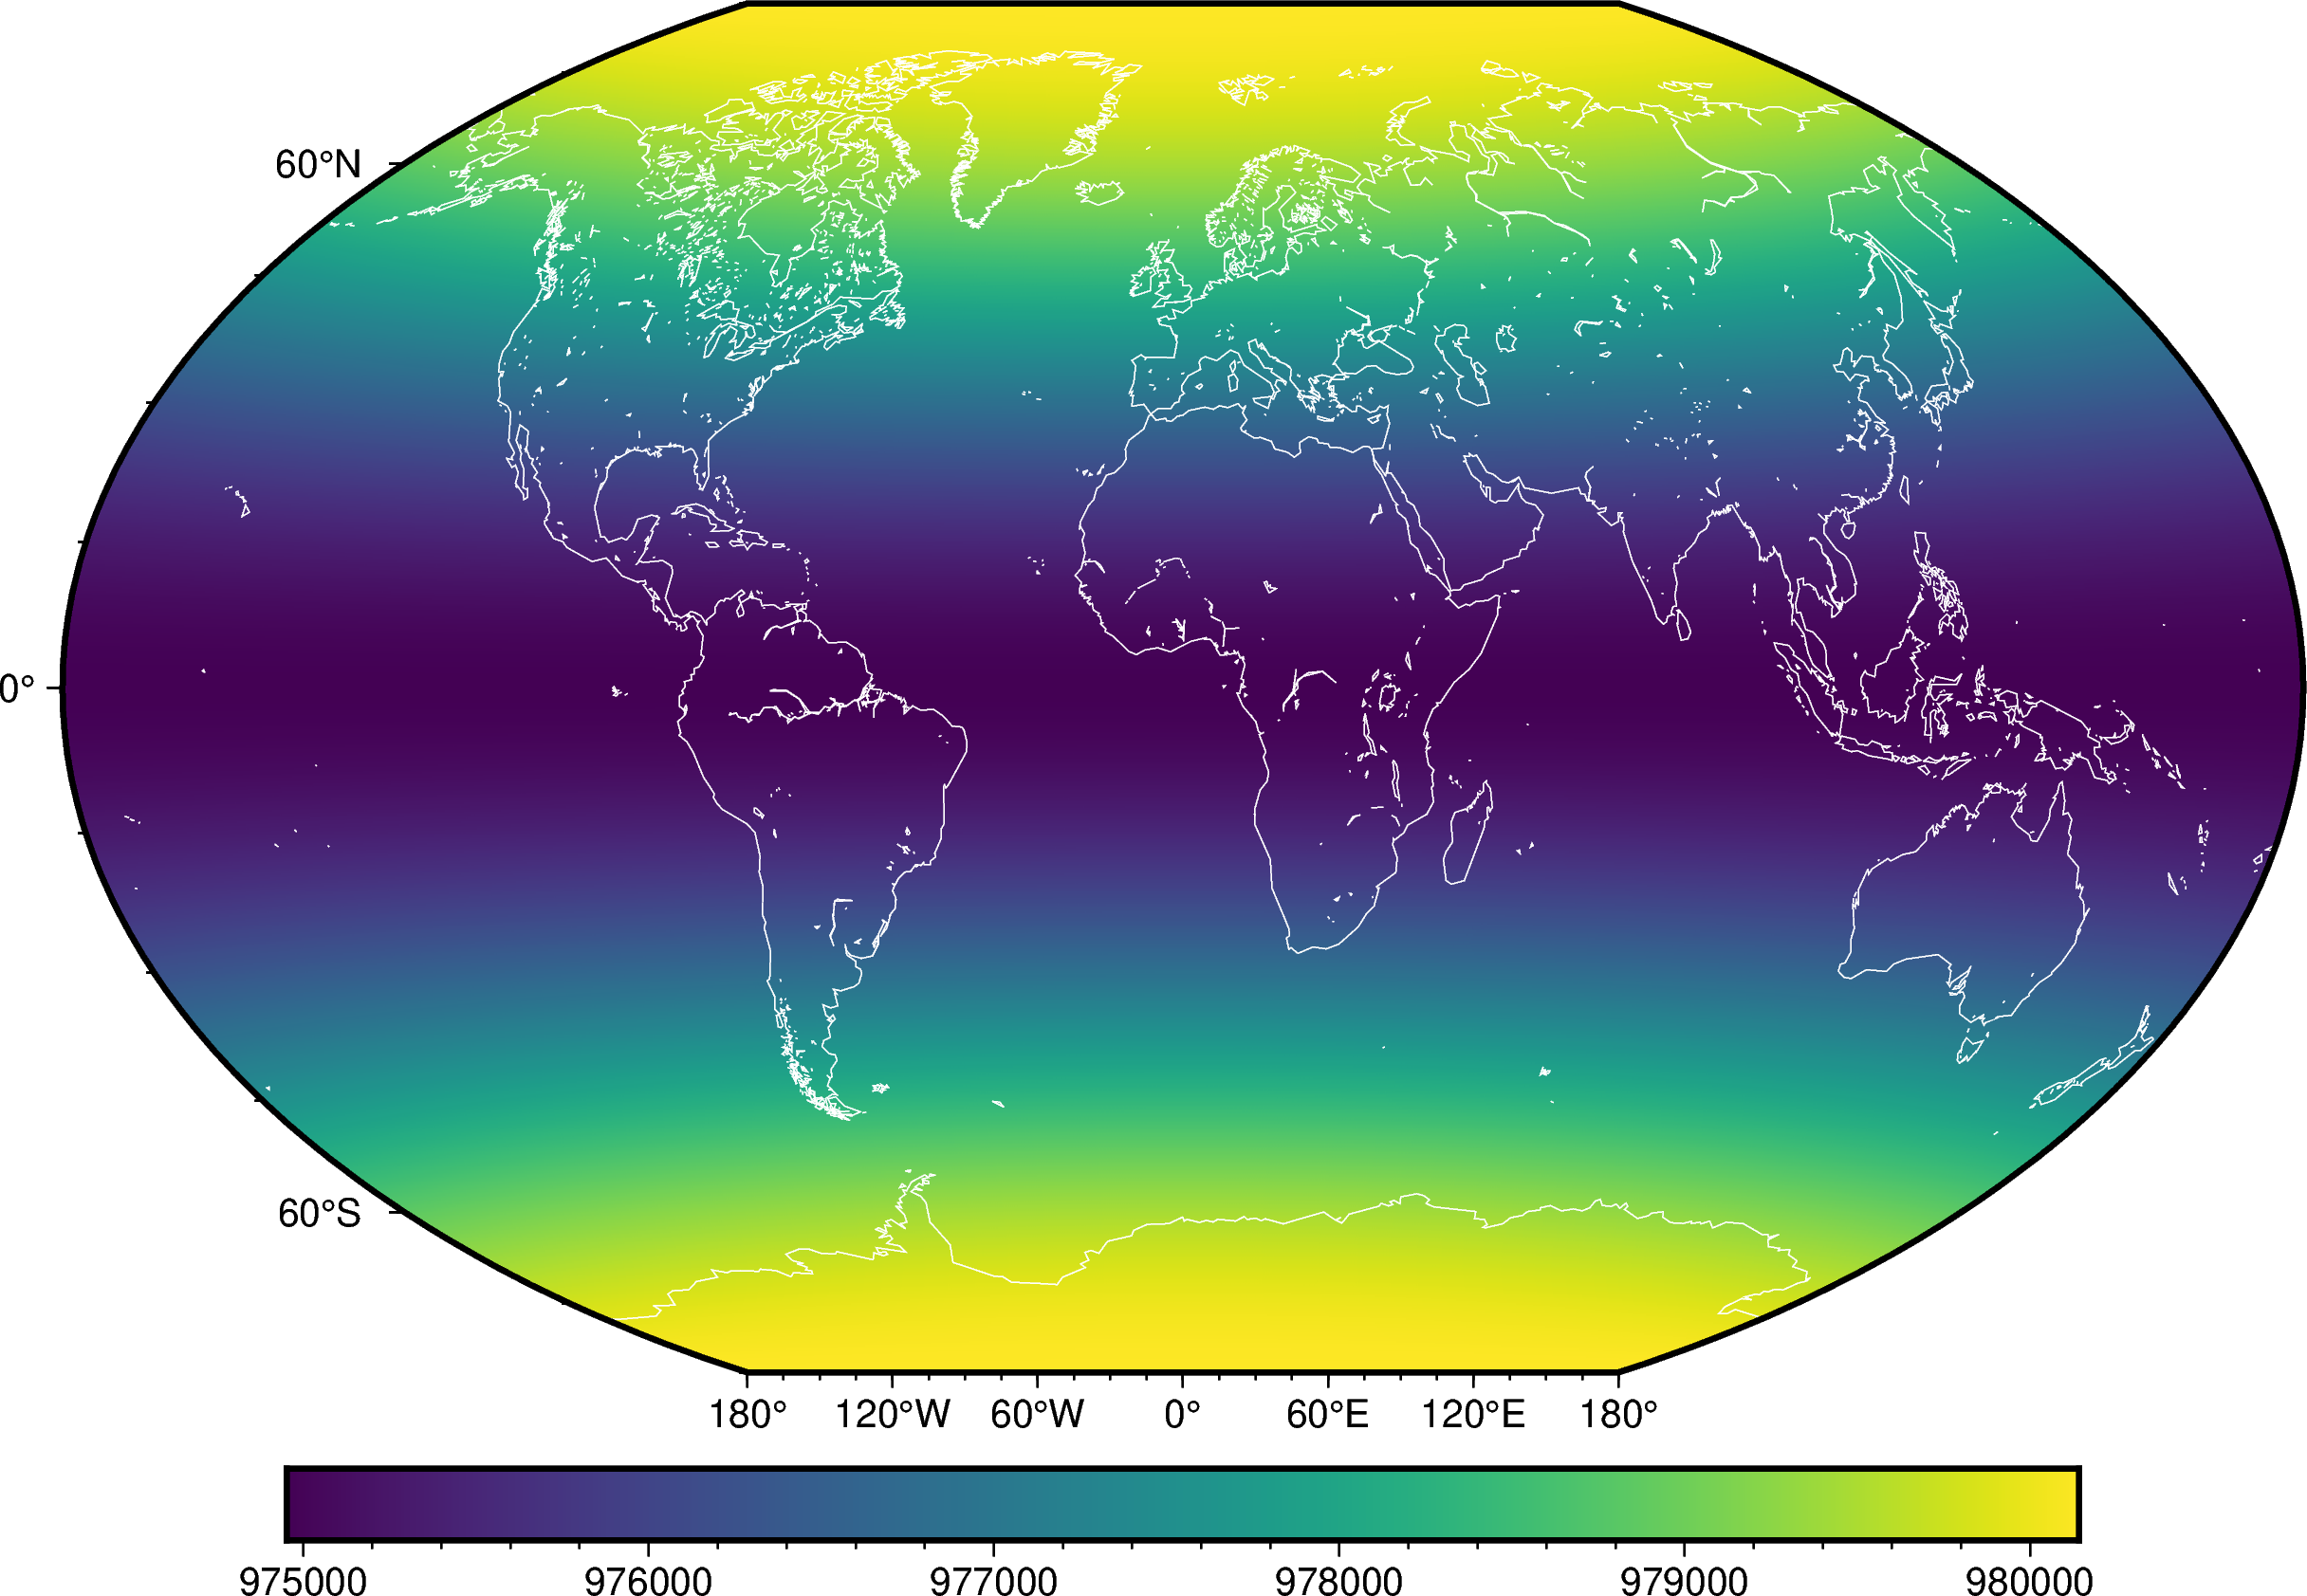

In [ ]:
fig = pygmt.Figure()
fig.grdimage(normal_gravity, projection="R20c", cmap="viridis")
fig.coast(shorelines="white", frame=True)
#fig.grdcontour(normal_gravity)
fig.colorbar()
fig.show(width=800)

## Altitudes

## Distúrbio da gravidade e anomalia da gravidade

In [ ]:
disturbance = gravity - normal_gravity

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


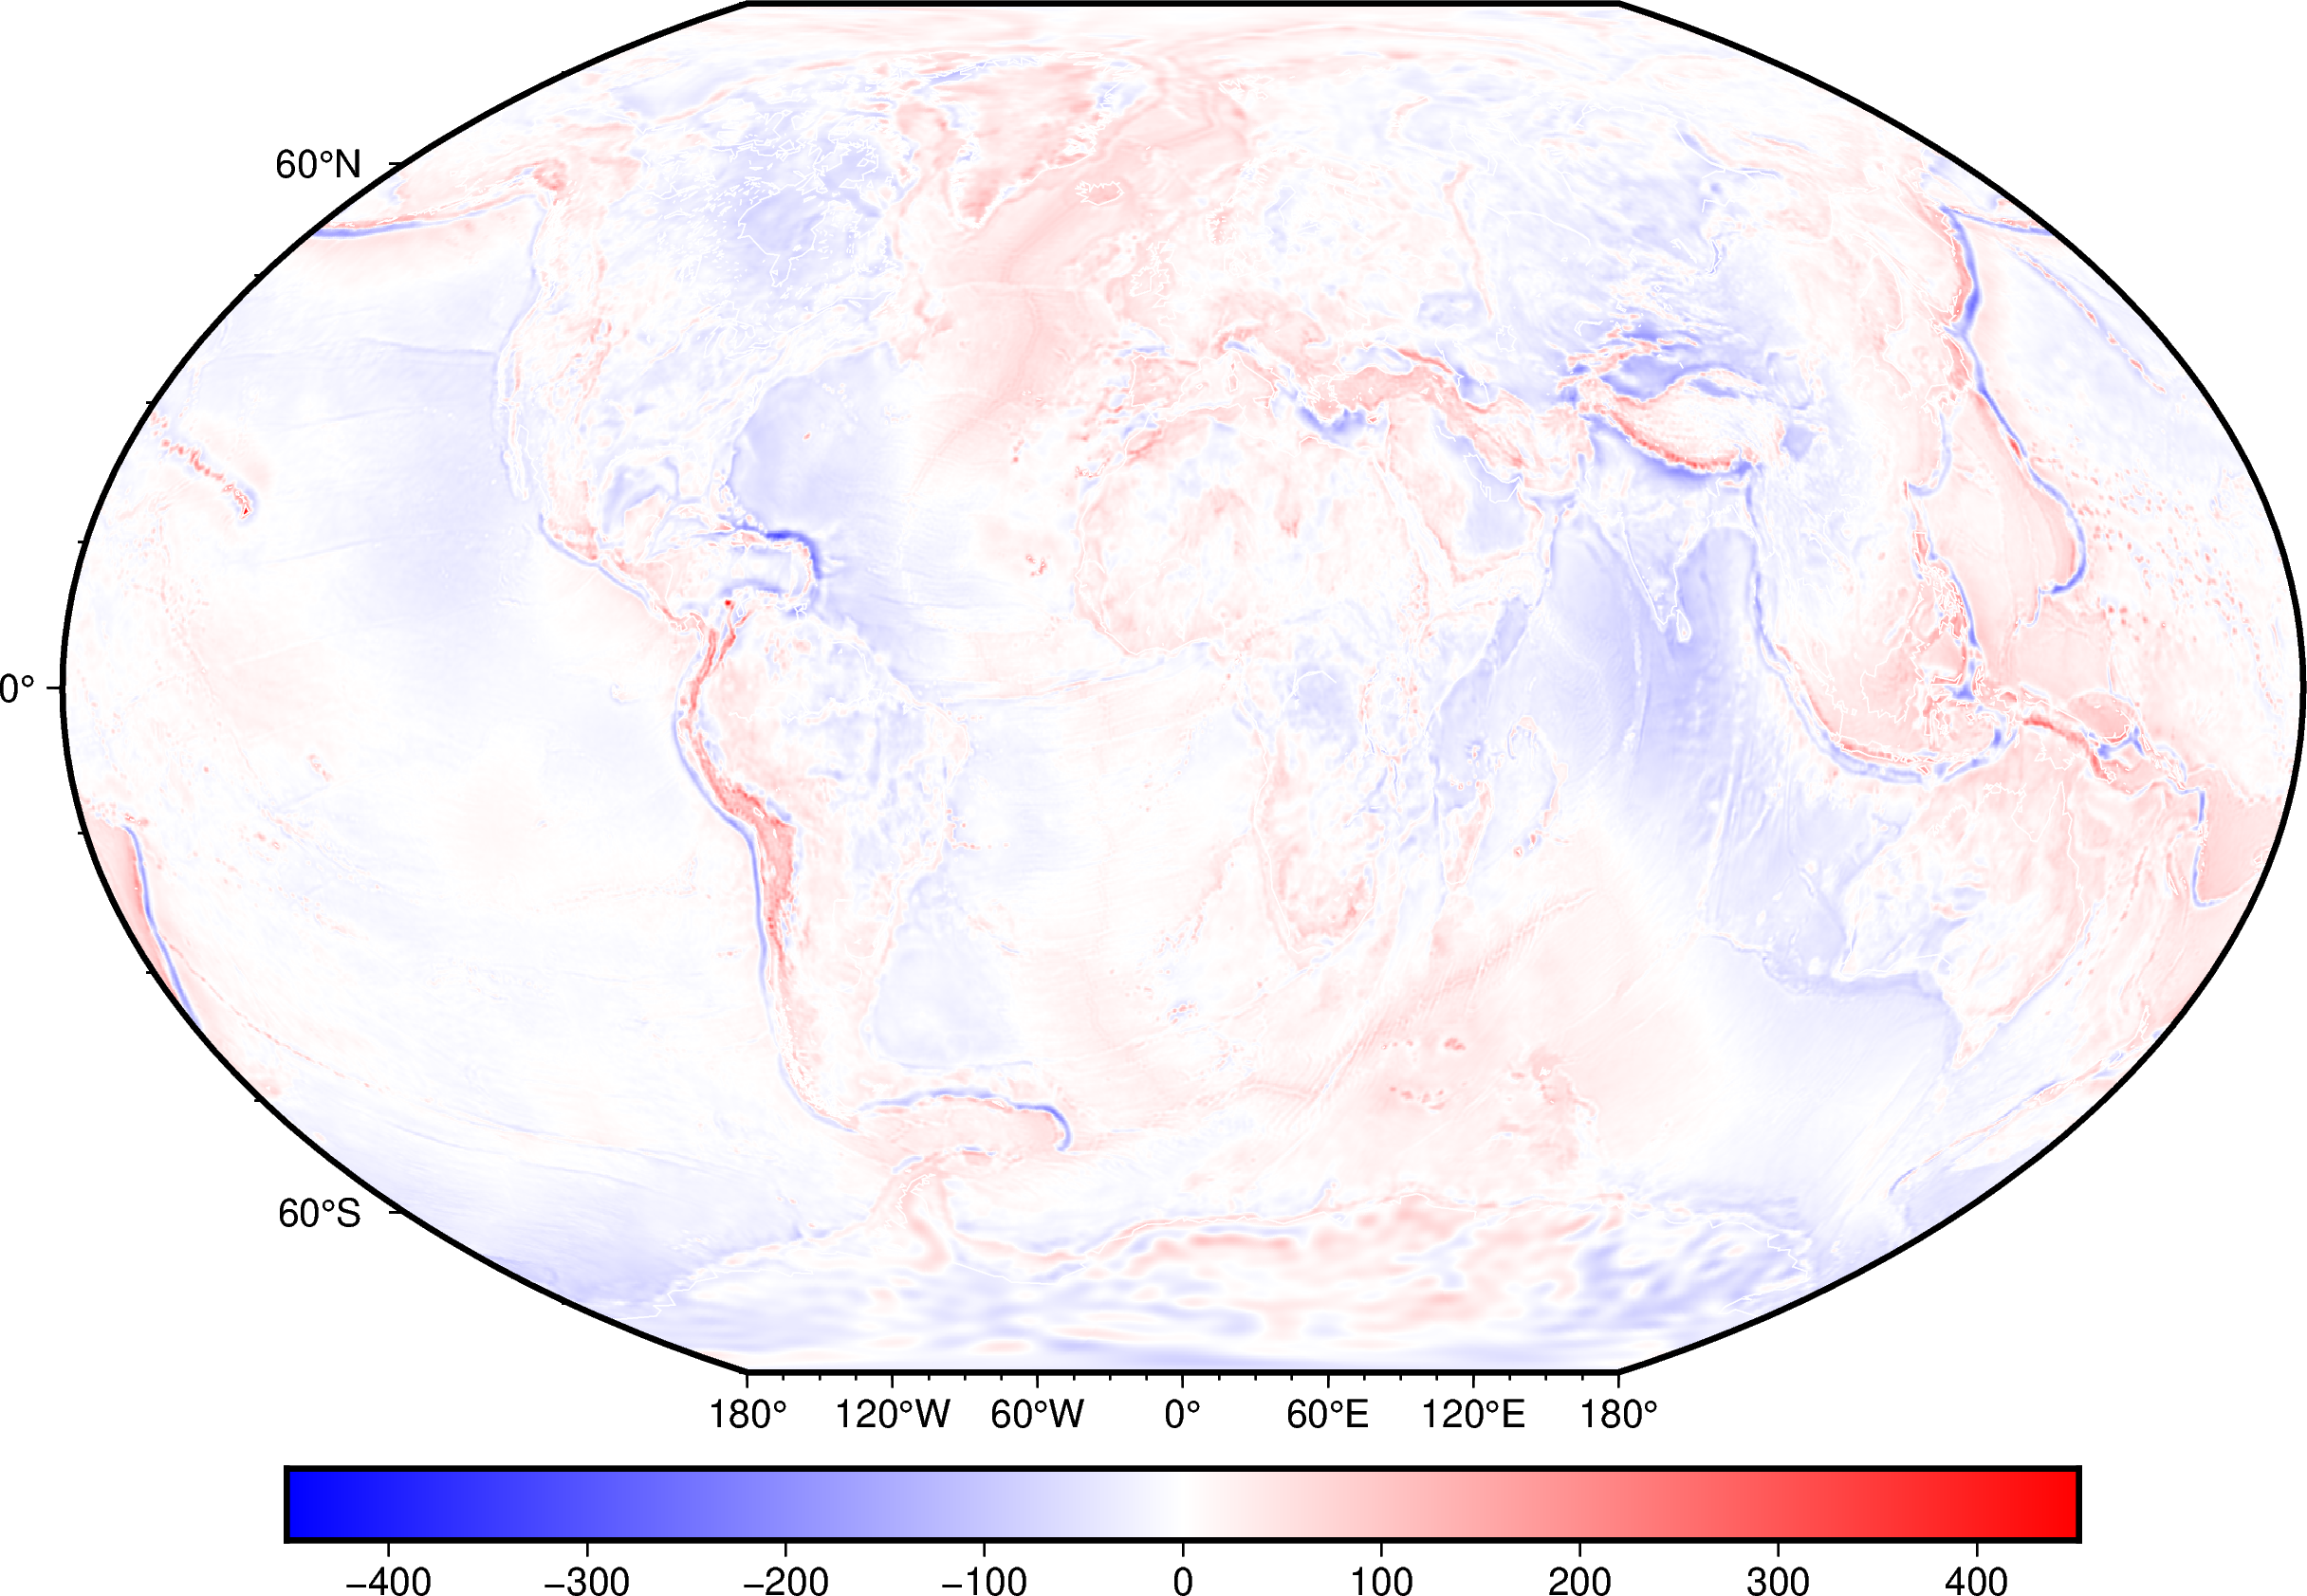

In [ ]:
fig = pygmt.Figure()
scale = vd.maxabs(disturbance)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.grdimage(disturbance, projection="R20c", cmap=True)
fig.coast(shorelines="white", frame=True)
fig.colorbar(frame="a")
fig.show(width=800)

In [ ]:
path = ensaio.fetch_earth_geoid(version=1)
geoid = xr.load_dataarray(path)
geoid

<xarray.DataArray 'geoid' (latitude: 1081, longitude: 2161)>
array([[-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.5     , -29.5     , -29.5     , ..., -29.5     , -29.5     ,
        -29.5     ],
       [-29.6     , -29.6     , -29.6     , ..., -29.6     , -29.6     ,
        -29.6     ],
       ...,
       [ 14.7     ,  14.7     ,  14.7     , ...,  14.7     ,  14.7     ,
         14.7     ],
       [ 15.2     ,  15.2     ,  15.2     , ...,  15.2     ,  15.2     ,
         15.2     ],
       [ 15.400001,  15.400001,  15.400001, ...,  15.400001,  15.400001,
         15.400001]], dtype=float32)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.8 -179.7 ... 179.7 179.8 180.0
  * latitude   (latitude) float64 -90.0 -89.83 -89.67 -89.5 ... 89.67 89.83 90.0
Attributes:
    Conventions:     CF-1.8
    title:           Geoid height (EIGEN-6C4) with respect to WGS84
    crs:             WGS84
    source:          Generated from the EIGEN-6C4 model by the ICGEM Calculat...
    license:         Creative Commons Attribution 4.0 International Licence
    references:      https://doi.org/10.5880/icgem.2015.1
    long_name:       geoid height
    standard_name:   geoid_height_above_reference_ellipsoid
    description:     height of the geoid with respect to the WGS84 ellipsoid
    units:           m
    actual_range:    [-106.5   86. ]
    icgem_metadata:  generating_institute: gfz-potsdam\ngenerating_date: 2021...

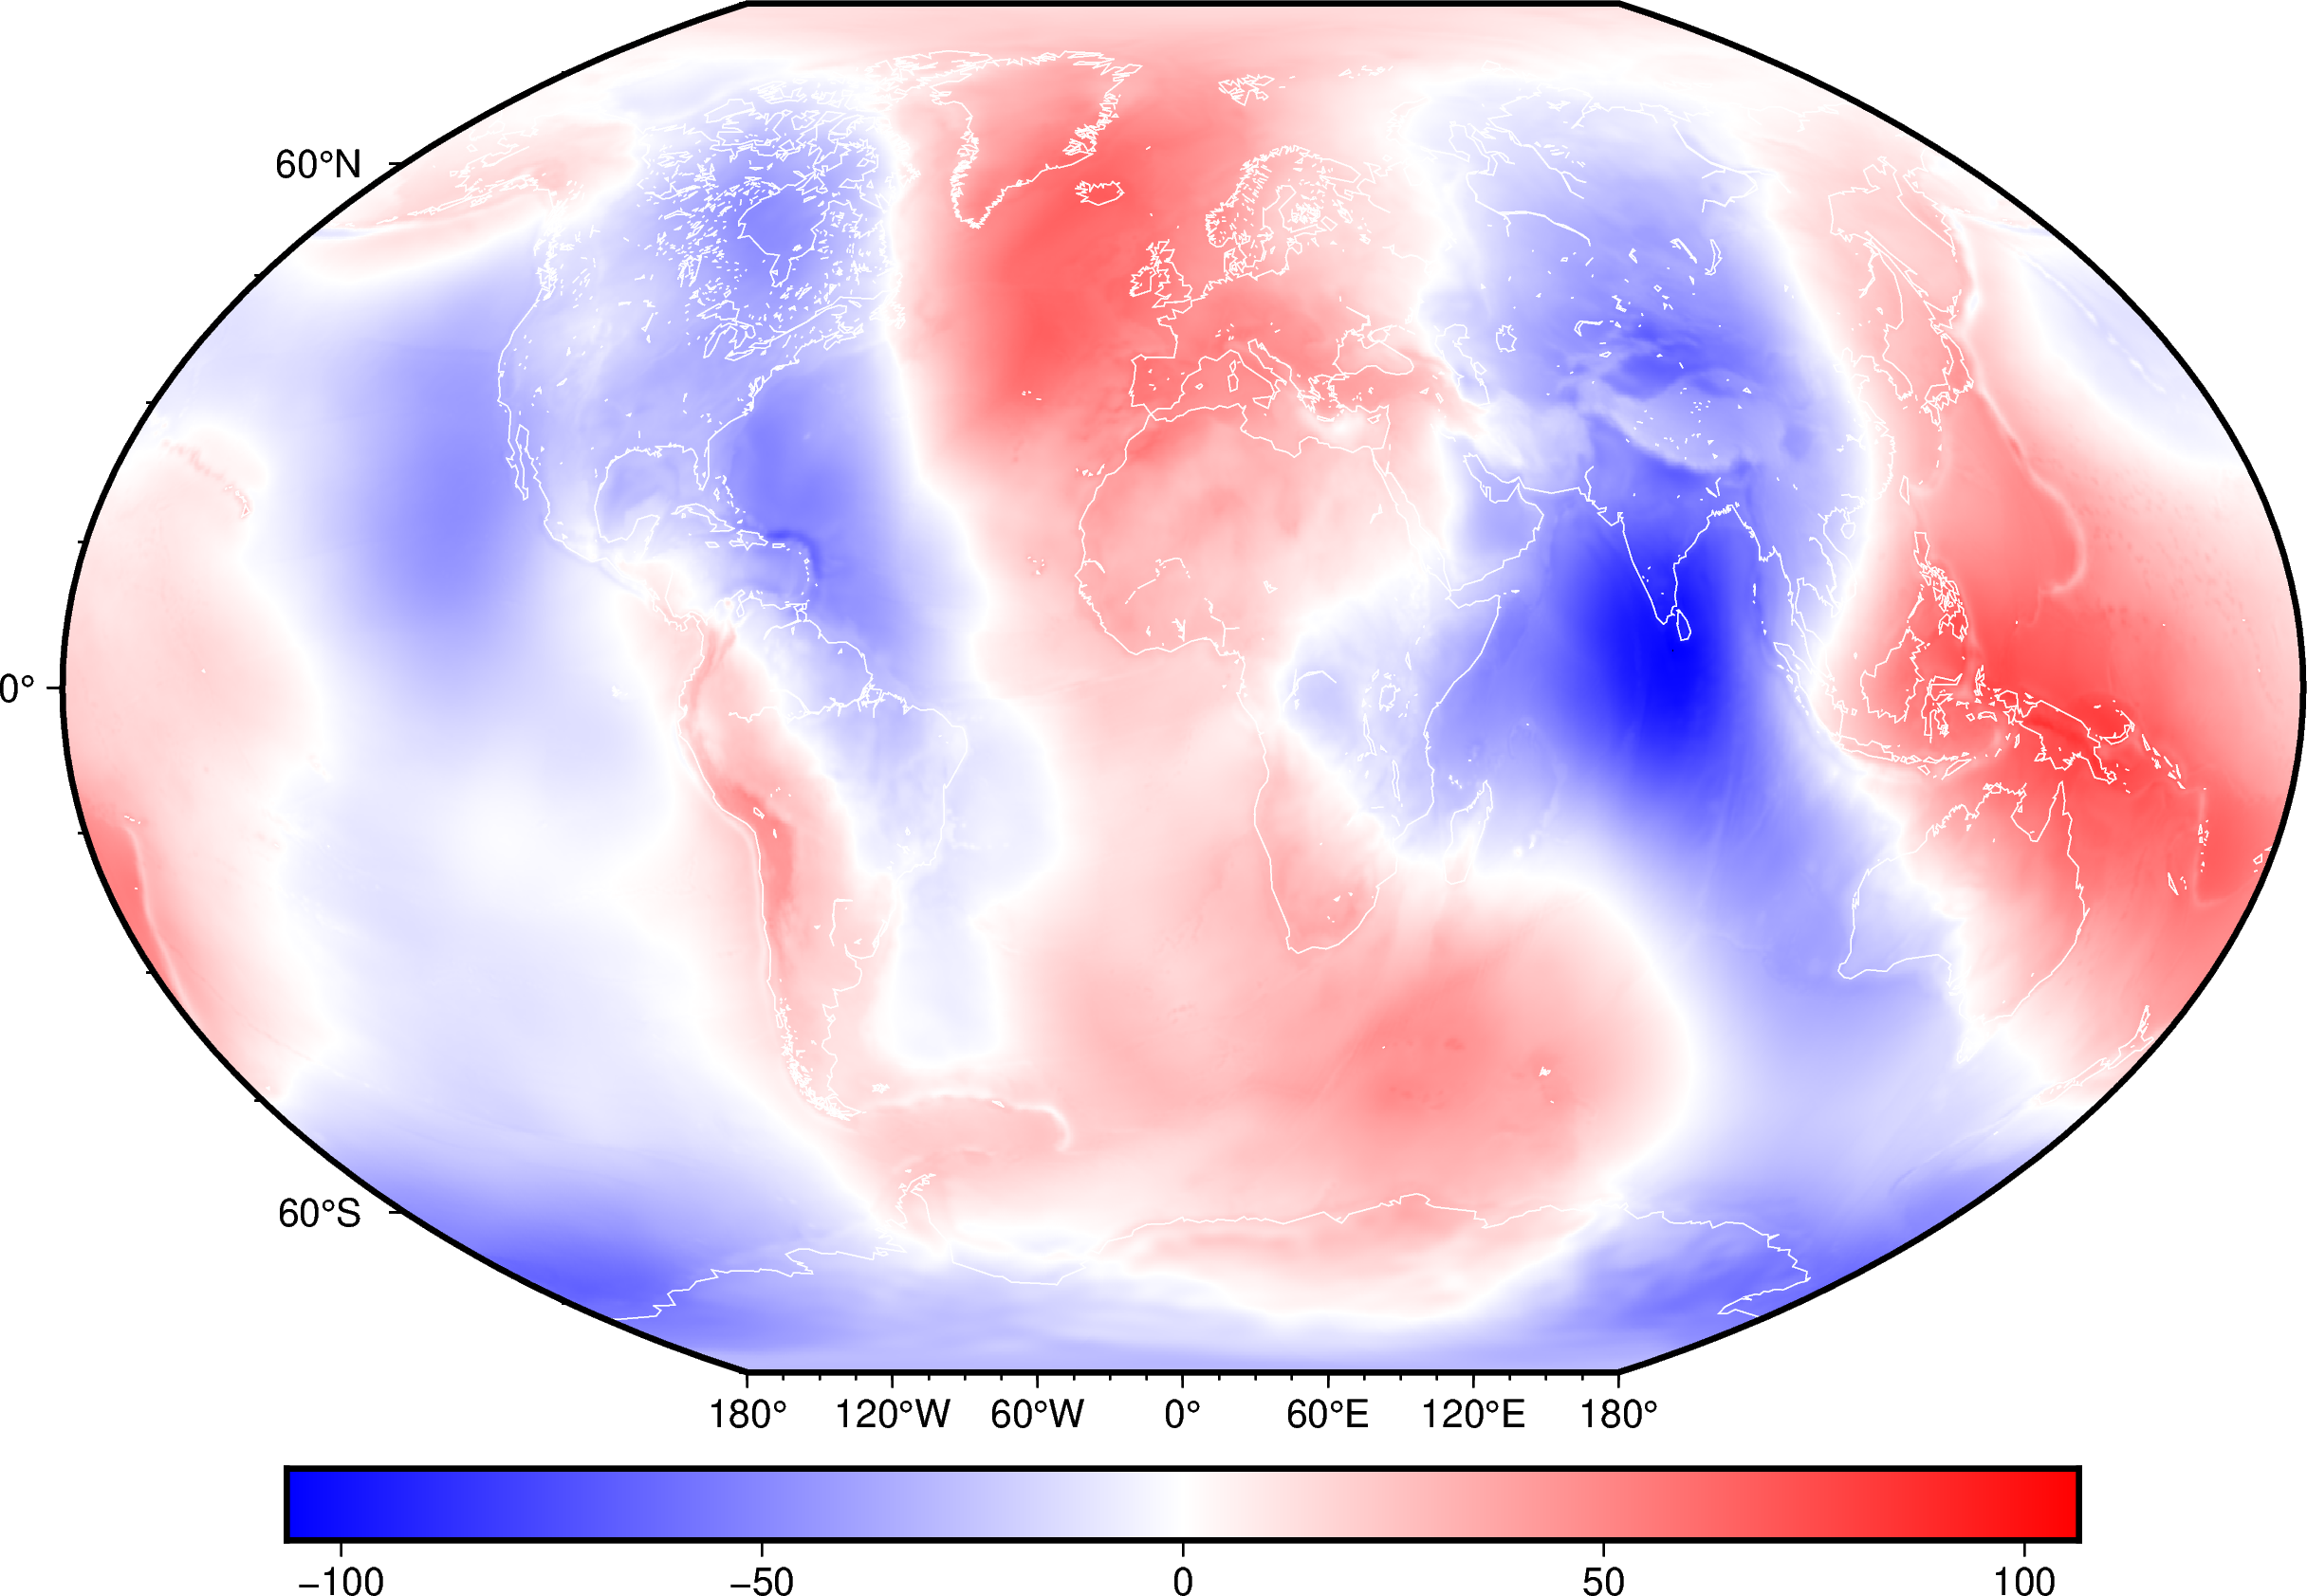

In [ ]:
fig = pygmt.Figure()
scale = vd.maxabs(geoid)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.grdimage(geoid, projection="R20c", cmap=True)
fig.coast(shorelines="white", frame=True)
fig.colorbar(frame="a")
fig.show(width=800)

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


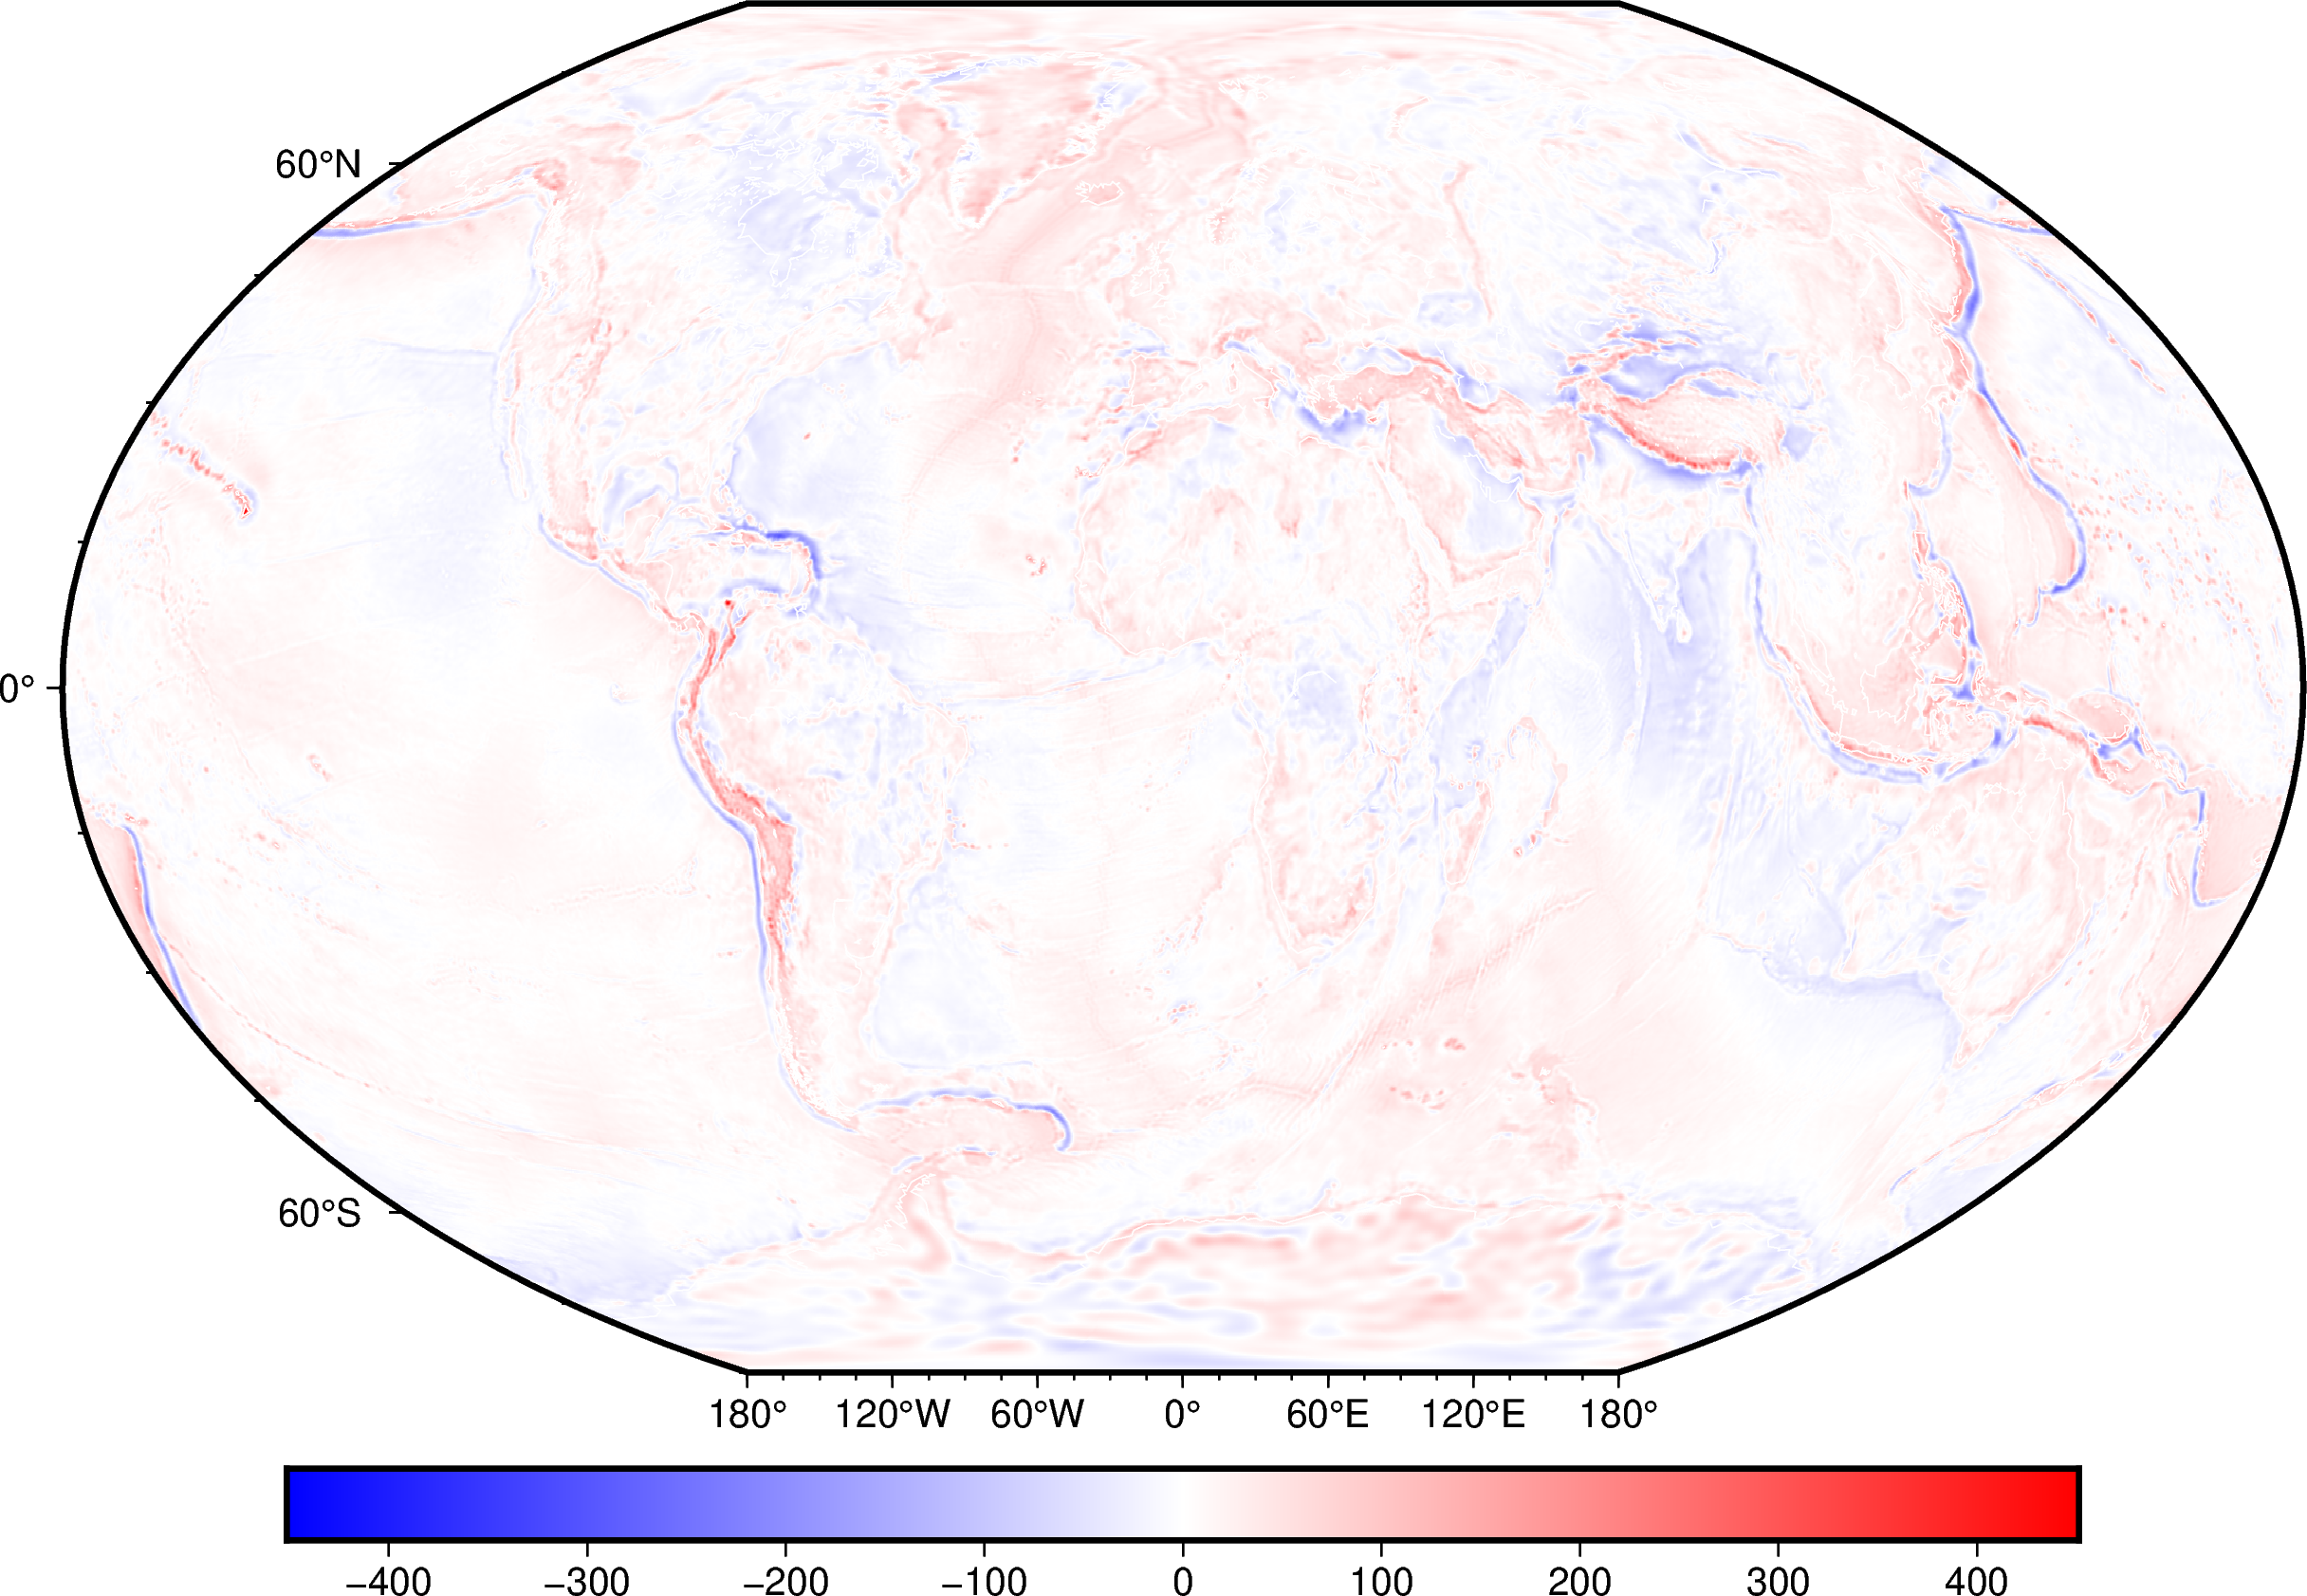

In [ ]:
freeair = gravity - bl.WGS84.normal_gravity(gravity.latitude, 0) + 0.3086 * (gravity.height - geoid)

fig = pygmt.Figure()
scale = vd.maxabs(disturbance)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.grdimage(freeair, projection="R20c", cmap=True)
fig.coast(shorelines="white", frame=True)
fig.colorbar(frame="a")
fig.show(width=800)

grdimage [WARNING]: Longitude range too small; geographic boundary condition changed to natural.


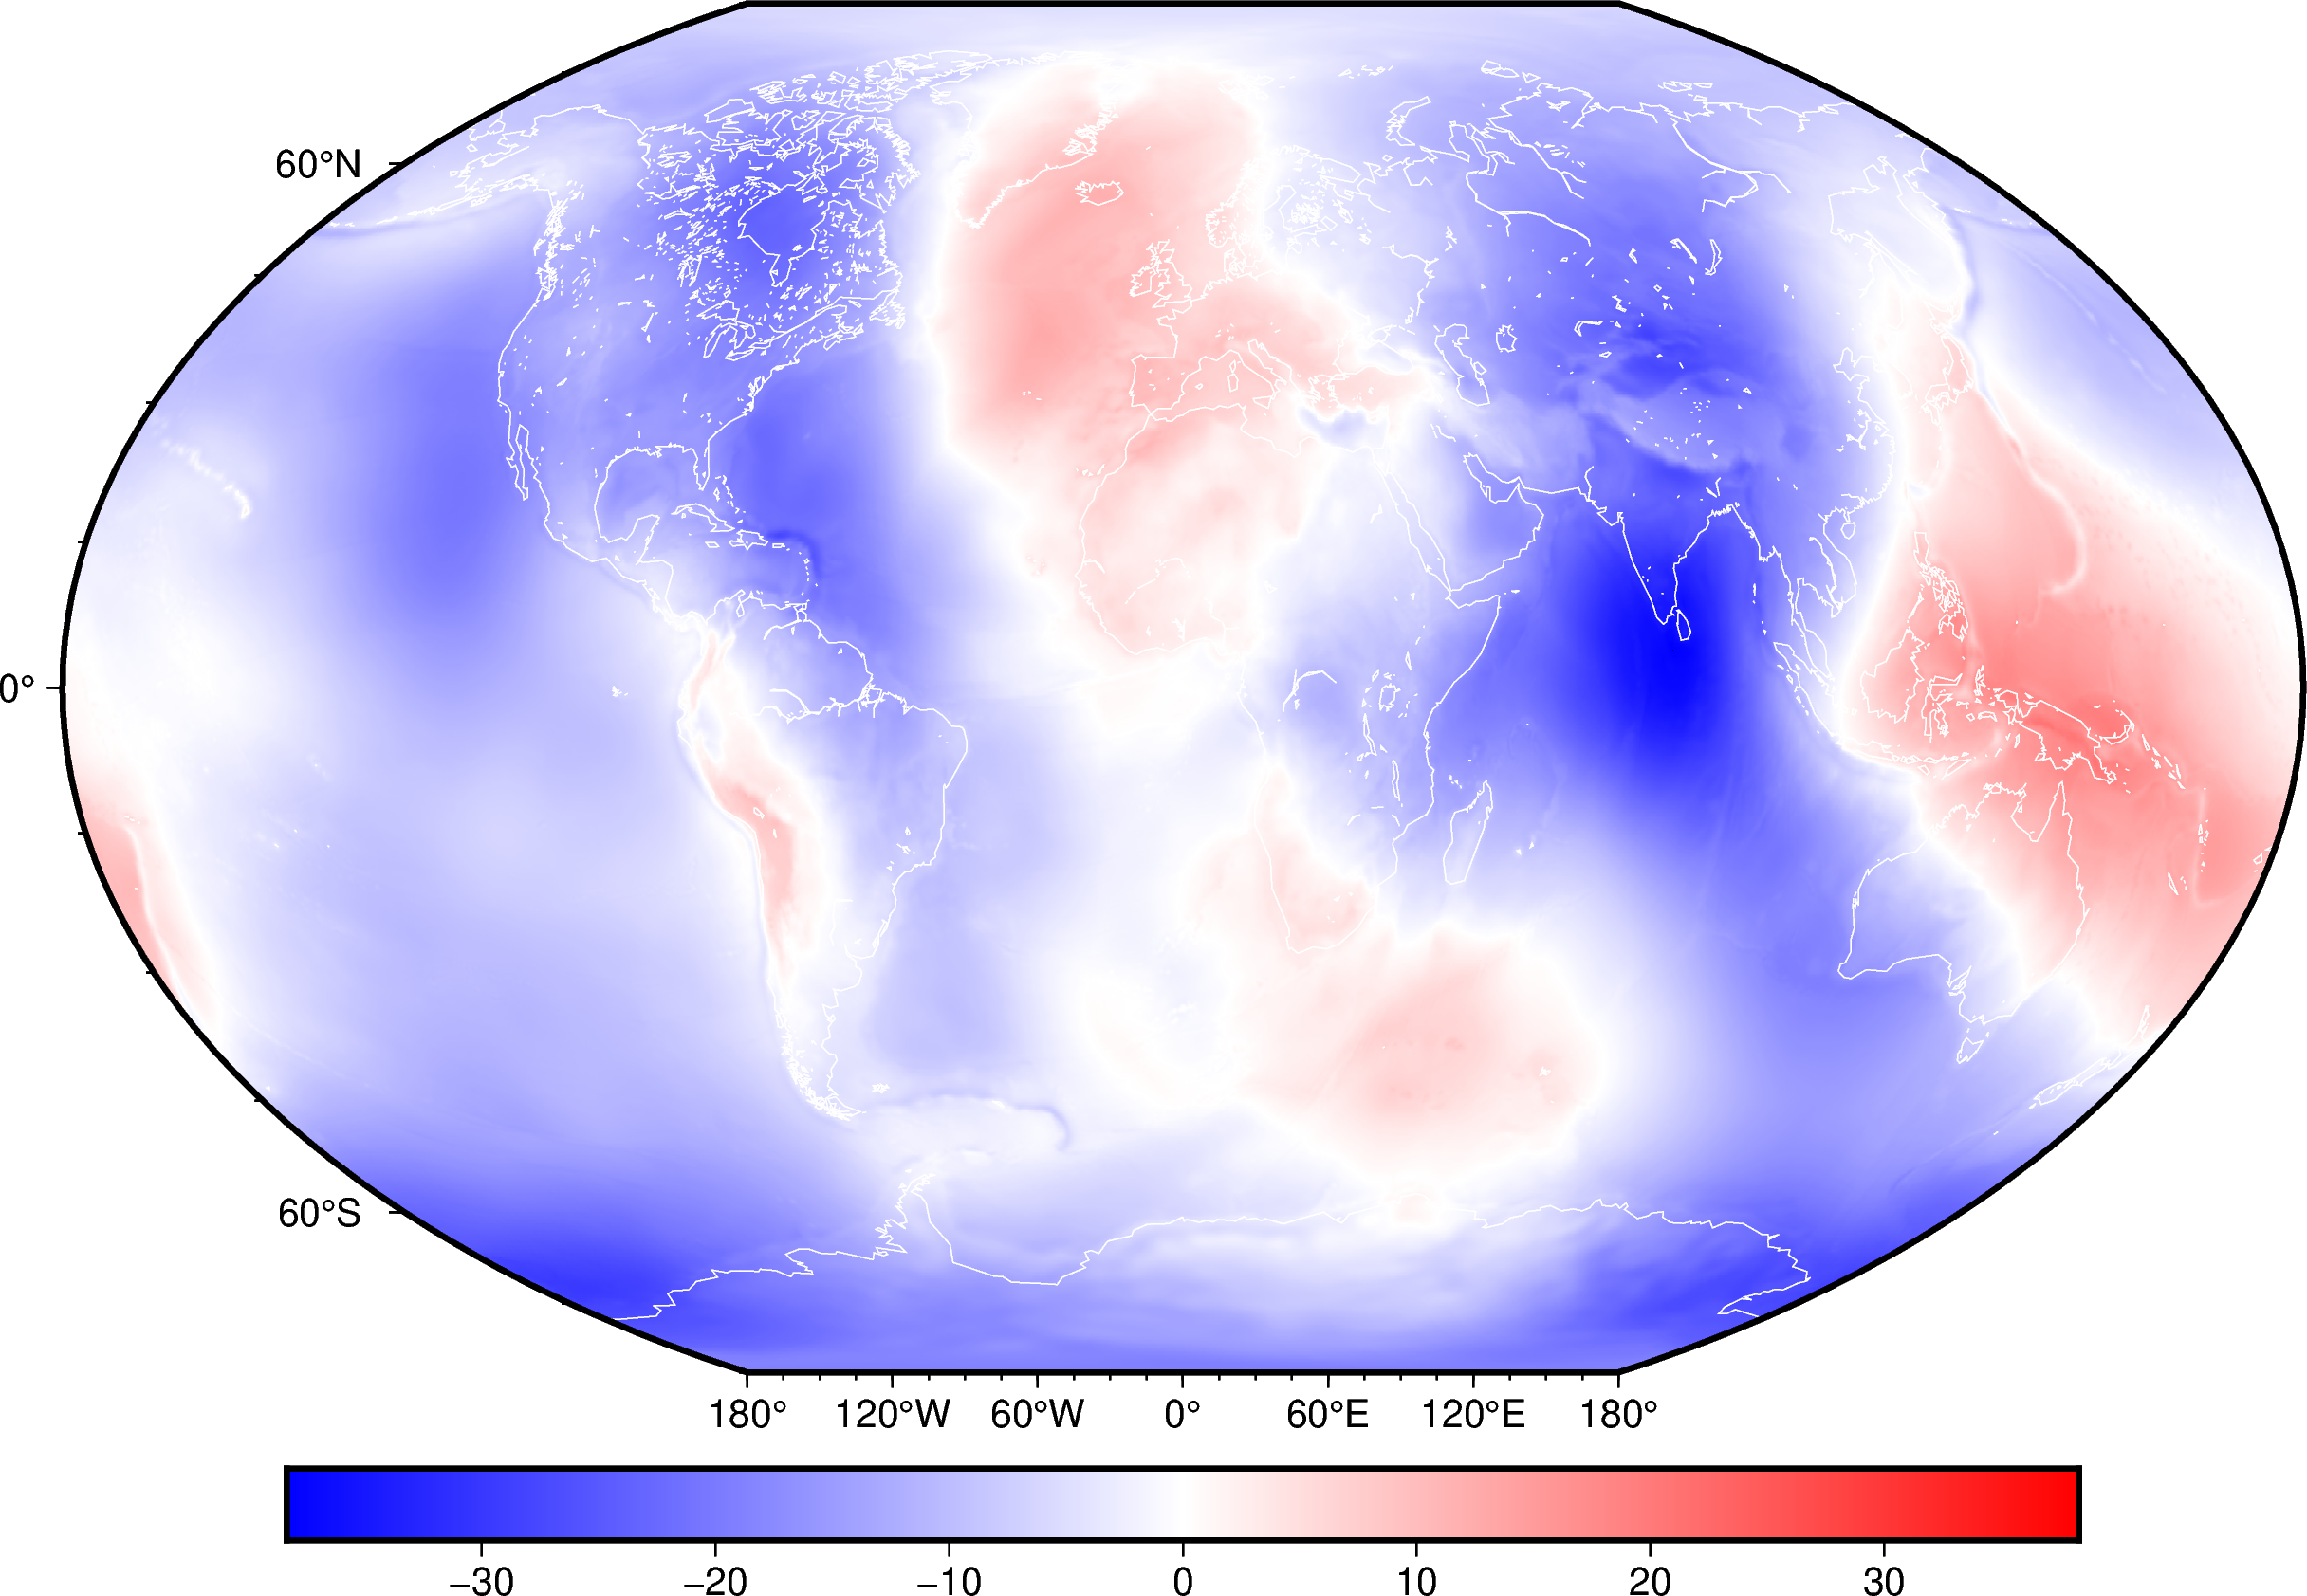

In [ ]:
difference = disturbance - freeair

fig = pygmt.Figure()
scale = vd.maxabs(difference)
pygmt.makecpt(cmap="polar", series=[-scale, scale])
fig.grdimage(difference, projection="R20c", cmap=True)
fig.coast(shorelines="white", frame=True)
fig.colorbar(frame="a")
fig.show(width=800)